# Agent Chat with Multimodal Models: DALLE  and GPT-4V

Requires: OpenAI V1.

### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install "autogen-agentchat[lmm]~=0.2"
```

In [ ]:
!pip install autogen-agentchat[lmm]~=0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
pip install autogen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.4/860.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.7 MB/s eta 0:00:00


In [ ]:
pip install diskcache

In [ ]:
import json
import os
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI
from PIL import Image
from termcolor import colored
from google.colab import userdata
import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, get_pil_image, gpt4v_formatter
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

In [ ]:
gpt_config = {
    "config_list": [{"model": "gpt-4-turbo-preview", "api_key": userdata.get('OPENAI_API_KEY')}],
    "timeout": 120,
    "temperature": 0.7,
}
gpt_vision_config = {
    "config_list": [{"model": "gpt-4o", "api_key": userdata.get('OPENAI_API_KEY')}],
    "timeout": 120,
    "temperature": 0.7,
}
dalle_config = {
    "config_list": [{"model": "dall-e-3", "api_key": userdata.get('OPENAI_API_KEY')}],
    "timeout": 120,
    "temperature": 0.7,
}

In [ ]:
# config_list_4v = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": ["gpt-4-vision-preview"],
#     },
# )

# config_list_gpt4 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
#     },
# )

# config_list_dalle = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": ["dalle"],
#     },
# )

# gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

The `config_list_dalle` should be something like:

```python
[
    {
        'model': 'dalle',
        'api_key': 'Your API Key here',
        'api_version': '2024-02-01'
    }
]
 ```

## Helper Functions

We first create a warpper for DALLE call, make the

In [ ]:
def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    """
    Generate an image using OpenAI's DALL-E model and cache the result.

    This function takes a prompt and other parameters to generate an image using OpenAI's DALL-E model.
    It checks if the result is already cached; if so, it returns the cached image data. Otherwise,
    it calls the DALL-E API to generate the image, stores the result in the cache, and then returns it.

    Args:
        client (OpenAI): The OpenAI client instance for making API calls.
        model (str): The specific DALL-E model to use for image generation.
        prompt (str): The text prompt based on which the image is generated.
        size (str): The size specification of the image. TODO: This should allow specifying landscape, square, or portrait modes.
        quality (str): The quality setting for the image generation.
        n (int): The number of images to generate.

    Returns:
    str: The image data as a string, either retrieved from the cache or newly generated.

    Note:
    - The cache is stored in a directory named '.cache/'.
    - The function uses a tuple of (model, prompt, size, quality, n) as the key for caching.
    - The image data is obtained by making a secondary request to the URL provided by the DALL-E API response.
    """
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

Here is a helper function to extract image from a DALLE agent. We will show the DALLE agent later.

In [ ]:
def extract_img(agent: Agent) -> PIL.Image:
    """
    Extracts an image from the last message of an agent and converts it to a PIL image.

    This function searches the last message sent by the given agent for an image tag,
    extracts the image data, and then converts this data into a PIL (Python Imaging Library) image object.

    Parameters:
        agent (Agent): An instance of an agent from which the last message will be retrieved.

    Returns:
        PIL.Image: A PIL image object created from the extracted image data.

    Note:
    - The function assumes that the last message contains an <img> tag with image data.
    - The image data is extracted using a regular expression that searches for <img> tags.
    - It's important that the agent's last message contains properly formatted image data for successful extraction.
    - The `_to_pil` function is used to convert the extracted image data into a PIL image.
    - If no <img> tag is found, or if the image data is not correctly formatted, the function may raise an error.
    """
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

## The DALLE Agent

In [ ]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            # config_list = llm_config["config_list"]
             api_key = llm_config["config_list"][0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = userdata.get('OPENAI_API_KEY')
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        # override and always "silent" the send out message;
        # otherwise, the print log would be super long!
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        # TODO: integrate with autogen.oai. For instance, with caching for the API call
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",  # TODO: the size should be flexible, deciding landscape, square, or portrait mode.
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

## Simple Example: Call directly from User

In [ ]:
dalle = DALLEAgent(name="Dalle", llm_config=dalle_config)

user_proxy = UserProxyAgent(
    name="User_proxy", system_message="A human admin.", human_input_mode="NEVER", max_consecutive_auto_reply=0
)

# Ask the question with an image
user_proxy.initiate_chat(
    dalle,
    message="""Create an image with black background, a happy robot is showing a sign with "I Love Coding".""",
)

User_proxy (to Dalle):

Create an image with black background, a happy robot is showing a sign with "I Love Coding".

--------------------------------------------------------------------------------

>>>>>>>> TERMINATING RUN (7f10e9c8-86ae-433a-a810-d4a2c3f366bc): Maximum number of consecutive auto-replies reached


ChatResult(chat_id=None, chat_history=[{'content': 'Create an image with black background, a happy robot is showing a sign with "I Love Coding".', 'role': 'assistant', 'name': 'User_proxy'}, {'content': [{'type': 'image_url', 'image_url': {'url': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x7F83ED3E6390>}}], 'role': 'user', 'name': 'Dalle'}], summary='', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

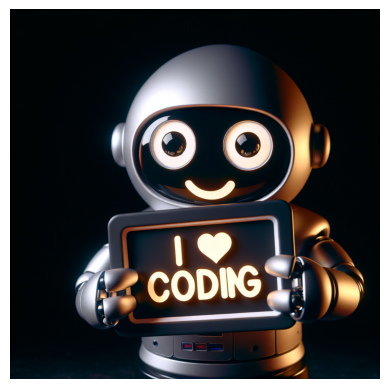

In [ ]:
img = extract_img(dalle)

plt.imshow(img)
plt.axis("off")  # Turn off axis numbers
plt.show()

## Example With Critics: Iterate several times to improve

In [ ]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a DalleCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among
        its child agents: dalle and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        ## Define the agents
        self.critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""You need to improve the prompt of the figures you saw.
How to create a figure that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

""",
            llm_config=gpt_vision_config,
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.dalle = DALLEAgent(
            name="Dalle", llm_config=dalle_config, max_consecutive_auto_reply=0
        )

        # Data flow begins
        self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
        img = extract_img(self.dalle)
        plt.imshow(img)
        plt.axis("off")  # Turn off axis numbers
        plt.show()
        print("Image PLOTTED")

        for i in range(self._n_iters):
            # Downsample the image s.t. GPT-4V can take
            img = extract_img(self.dalle)
            smaller_image = img.resize((128, 128), Image.Resampling.LANCZOS)
            smaller_image.save("result.png")

            self.msg_to_critics = f"""Here is the prompt: {img_prompt}.
            Here is the figure <img result.png>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            """
            self.send(message=self.msg_to_critics, recipient=self.critics, request_reply=True)
            feedback = self._oai_messages[self.critics][-1]["content"]
            img_prompt = re.findall("PROMPT: (.*)", feedback)[0]

            self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
            img = extract_img(self.dalle)
            plt.imshow(img)
            plt.axis("off")  # Turn off axis numbers
            plt.show()
            print(f"Image {i} PLOTTED")

        return True, "result.jpg"

User (to DALLE_Creator!):

Create an image with black background, a happy robot is showing a sign with "I Love Coding".

--------------------------------------------------------------------------------
DALLE_Creator! (to Dalle):

Create an image with black background, a happy robot is showing a sign with "I Love Coding".

--------------------------------------------------------------------------------


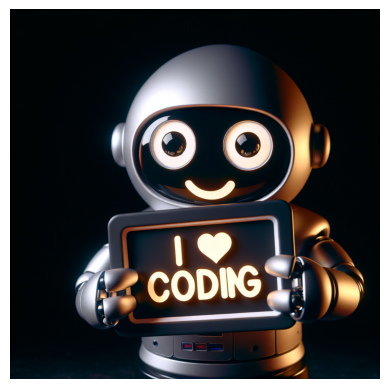

Image PLOTTED
DALLE_Creator! (to Critics):

Here is the prompt: Create an image with black background, a happy robot is showing a sign with "I Love Coding"..
            Here is the figure 
<image>
.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE_Creator!):

CRITICS: The image could be improved by adding more vibrant colors to make the robot more visually appealing. The text on the sign could be larger and more prominent for better readability. Additionally, adding some subtle lighting effects could enhance the overall atmosphere.

PROMPT: Create an image with a black background featuring a happy robot. The robot should be colorful and visually appealing, holding a clearly visible sign with large, bold text that says "I Love Coding". Add soft lighting effects to enhance the mood and make 

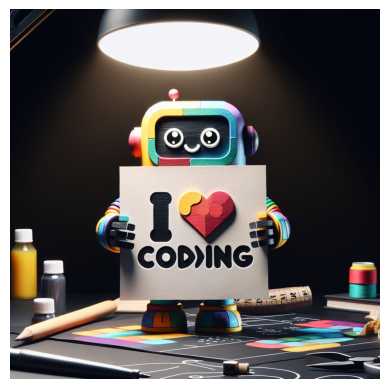

Image 0 PLOTTED
DALLE_Creator! (to Critics):

Here is the prompt: Create an image with a black background featuring a happy robot. The robot should be colorful and visually appealing, holding a clearly visible sign with large, bold text that says "I Love Coding". Add soft lighting effects to enhance the mood and make the scene more dynamic..
            Here is the figure 
<image>
.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE_Creator!):

CRITICS: The image is visually appealing, but it could benefit from additional elements to create a more engaging scene. Adding more coding-related items around the robot, such as a laptop or code snippets, could enhance the theme. The lighting could also be adjusted for a more dramatic effect.

PROMPT: Create an image with a black background featuring

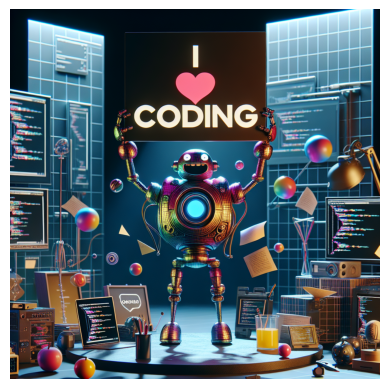

Image 1 PLOTTED
DALLE_Creator! (to User):

result.jpg

--------------------------------------------------------------------------------

>>>>>>>> TERMINATING RUN (57c406e5-dcc1-4e82-9a7d-8cc852b84841): Maximum number of consecutive auto-replies reached


ChatResult(chat_id=None, chat_history=[{'content': 'Create an image with black background, a happy robot is showing a sign with "I Love Coding".', 'role': 'assistant', 'name': 'User'}, {'content': 'result.jpg', 'role': 'user', 'name': 'DALLE_Creator!'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [ ]:
creator = DalleCreator(
    name="DALLE_Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Create an image with black background, a happy robot is showing a sign with "I Love Coding"."""
)

User (to DALLE_Creator!):

A lone astronaut is floating in space, surrounded by vibrant nebulae, holding a glowing orb.

--------------------------------------------------------------------------------
DALLE_Creator! (to Dalle):

A lone astronaut is floating in space, surrounded by vibrant nebulae, holding a glowing orb.

--------------------------------------------------------------------------------


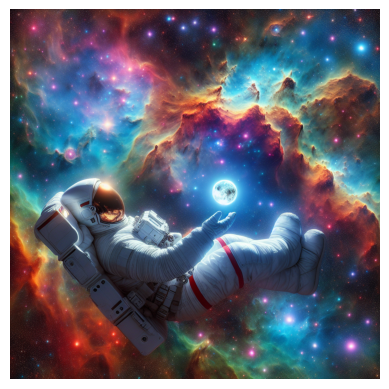

Image PLOTTED
DALLE_Creator! (to Critics):

Here is the prompt: A lone astronaut is floating in space, surrounded by vibrant nebulae, holding a glowing orb..
            Here is the figure 
<image>
.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE_Creator!):

CRITICS: The image could be improved by enhancing the brightness and contrast to make the nebulae more vivid. The glowing orb could have a more noticeable glow effect. The astronaut's suit might benefit from additional detail and texture to make it more realistic.

PROMPT: A lone astronaut in a detailed, realistic space suit is floating in space, surrounded by vividly colorful and bright nebulae. The astronaut is holding a glowing orb that emits a soft, radiant light, creating an ethereal glow around it. The background is filled with 

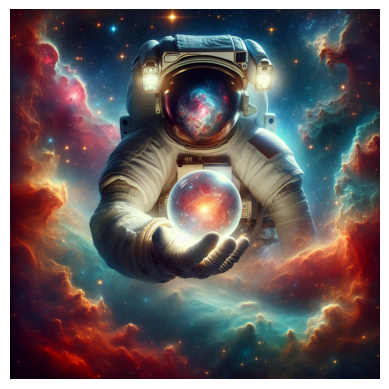

Image 0 PLOTTED
DALLE_Creator! (to Critics):

Here is the prompt: A lone astronaut in a detailed, realistic space suit is floating in space, surrounded by vividly colorful and bright nebulae. The astronaut is holding a glowing orb that emits a soft, radiant light, creating an ethereal glow around it. The background is filled with stars, enhancing the sense of depth in space..
            Here is the figure 
<image>
.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE_Creator!):

CRITICS: The image is visually striking, but it could be improved by adding more distinct textures to the astronaut's suit for enhanced realism. Increasing the intensity of the orb's glow could create a more dramatic effect. The nebulae could have more defined patterns to add interest, and the star field could be more

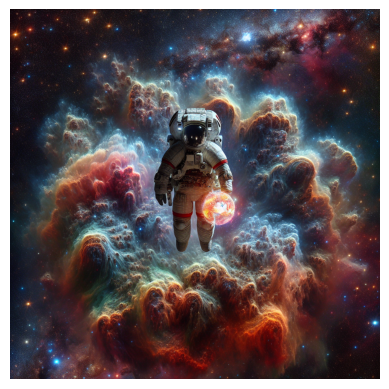

Image 1 PLOTTED
DALLE_Creator! (to User):

result.jpg

--------------------------------------------------------------------------------

>>>>>>>> TERMINATING RUN (8d2f69bf-cfb4-4a0c-a248-5232adc11d4d): Maximum number of consecutive auto-replies reached


ChatResult(chat_id=None, chat_history=[{'content': 'A lone astronaut is floating in space, surrounded by vibrant nebulae, holding a glowing orb.', 'role': 'assistant', 'name': 'User'}, {'content': 'result.jpg', 'role': 'user', 'name': 'DALLE_Creator!'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [ ]:
creator = DalleCreator(
    name="DALLE_Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""A lone astronaut is floating in space, surrounded by vibrant nebulae, holding a glowing orb."""
)

User (to DALLE_Creator!):

A majestic dragon with iridescent scales is perched on a rocky mountain peak at sunrise.

--------------------------------------------------------------------------------
DALLE_Creator! (to Dalle):

A majestic dragon with iridescent scales is perched on a rocky mountain peak at sunrise.

--------------------------------------------------------------------------------


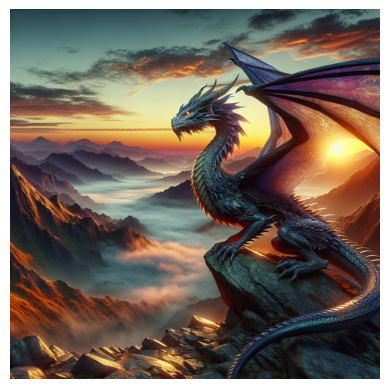

Image PLOTTED
DALLE_Creator! (to Critics):

Here is the prompt: A majestic dragon with iridescent scales is perched on a rocky mountain peak at sunrise..
            Here is the figure 
<image>
.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE_Creator!):

CRITICS: The image is visually stunning, but to enhance it further, consider focusing on the following aspects:
- **Color**: Ensure the iridescent scales reflect a broader range of colors, such as blues, purples, and greens, to emphasize their shimmering quality.
- **Lighting**: Accentuate the sunrise with a warm glow, highlighting the dragon’s scales and the mountain peak.
- **Detail**: Add more intricate details to the dragon's scales and wings to create a sense of realism.
- **Composition**: Improve the sense of scale by showing more o

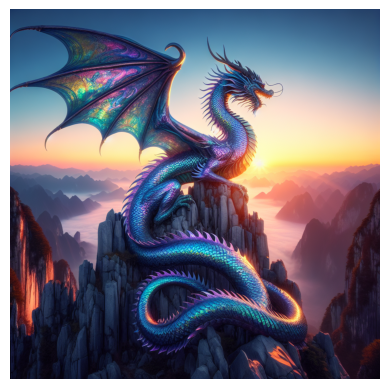

Image 0 PLOTTED
DALLE_Creator! (to Critics):

Here is the prompt: A majestic dragon with shimmering iridescent scales reflecting blues, purples, and greens, perched on a rocky mountain peak at sunrise. The warm glow of the sunrise casts vibrant colors across the scene, highlighting the intricate details of the dragon's scales and expansive wings. The background reveals a vast mountain range shrouded in mist, enhancing the grandeur of the setting..
            Here is the figure 
<image>
.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE_Creator!):

CRITICS: The image is impressive, but to further enhance it, consider the following improvements:
- **Contrast**: Increase the contrast between the dragon and the background to make the dragon stand out more prominently.
- **Atmosphere**: Enhance

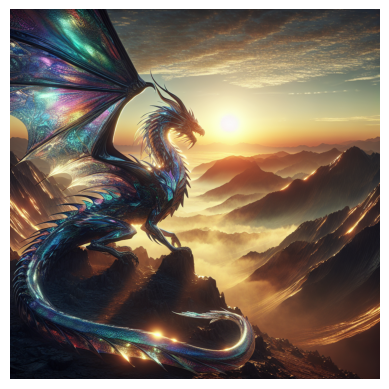

Image 1 PLOTTED
DALLE_Creator! (to User):

result.jpg

--------------------------------------------------------------------------------

>>>>>>>> TERMINATING RUN (1b645b60-e316-4ea5-88da-05c1402aa157): Maximum number of consecutive auto-replies reached


ChatResult(chat_id=None, chat_history=[{'content': 'A majestic dragon with iridescent scales is perched on a rocky mountain peak at sunrise.', 'role': 'assistant', 'name': 'User'}, {'content': 'result.jpg', 'role': 'user', 'name': 'DALLE_Creator!'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [ ]:
creator = DalleCreator(
    name="DALLE_Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""A majestic dragon with iridescent scales is perched on a rocky mountain peak at sunrise."""
)

User (to DALLE_Creator!):

A group of robots laughing at a computer joke: “Why do Java devs wear glasses? Because they can't C#".

--------------------------------------------------------------------------------
DALLE_Creator! (to Dalle):

A group of robots laughing at a computer joke: “Why do Java devs wear glasses? Because they can't C#".

--------------------------------------------------------------------------------


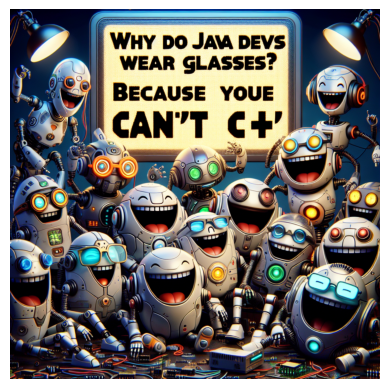

Image PLOTTED
DALLE_Creator! (to Critics):

Here is the prompt: A group of robots laughing at a computer joke: “Why do Java devs wear glasses? Because they can't C#"..
            Here is the figure 
<image>
.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE_Creator!):

CRITICS: The image is vibrant and captures the humor well, but there are a few areas for improvement:
- The text on the sign could be clearer and more prominent.
- The expression of the robots should be more diverse to enhance the humor.
- The setting could be more defined to add context, like a tech-themed environment.

PROMPT: A group of diverse robots with expressive faces, gathered in a futuristic tech-themed room, laughing at a computer joke. A large, clear sign in the background reads, "Why do Java devs wear glasses? B

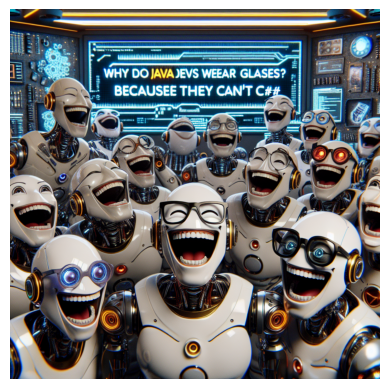

Image 0 PLOTTED
DALLE_Creator! (to Critics):

Here is the prompt: A group of diverse robots with expressive faces, gathered in a futuristic tech-themed room, laughing at a computer joke. A large, clear sign in the background reads, "Why do Java devs wear glasses? Because they can't C#". The robots display a variety of reactions, enhancing the humor, while the setting includes elements like circuit boards and screens for a more immersive atmosphere..
            Here is the figure 
<image>
.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE_Creator!):

CRITICS: The image captures the humor and the setting well, but there are a few suggestions for further enhancement:
- The robots could have more varied designs to showcase diversity.
- The text could be more stylized to fit the futuristic them

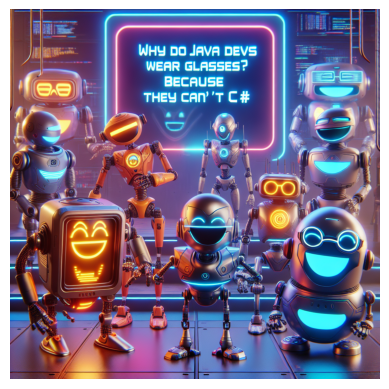

Image 1 PLOTTED
DALLE_Creator! (to User):

result.jpg

--------------------------------------------------------------------------------

>>>>>>>> TERMINATING RUN (81e0222e-da87-41d6-8ca9-e312bd4ce741): Maximum number of consecutive auto-replies reached


ChatResult(chat_id=None, chat_history=[{'content': 'A group of robots laughing at a computer joke: “Why do Java devs wear glasses? Because they can\'t C#".', 'role': 'assistant', 'name': 'User'}, {'content': 'result.jpg', 'role': 'user', 'name': 'DALLE_Creator!'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [ ]:
creator = DalleCreator(
    name="DALLE_Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""A group of robots laughing at a computer joke: “Why do Java devs wear glasses? Because they can't C#"."""
)